## Libraries

In [5]:
import requests

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# You might need to download the NLTK resources the first time you run the script
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Import Data

In [2]:
symbol = "AMD"
year = 2023
quarter = 3
api_key = 'your_api_key_here'
url = f'https://financialmodelingprep.com/api/v3/earning_call_transcript/{symbol}?year={year}&quarter={quarter}&apikey={api_key}'
data = requests.get(url).json()
transcript = data[0]['content']

## Processing

In [3]:
# Tokenize the text into sentences
sentences = sent_tokenize(transcript)

# Tokenize and preprocess each sentence
processed_sentences = []
for sentence in sentences:

    # Remove words with a colon immediately following them
    sentence = ' '.join([word for word in sentence.split() if ':' not in word])

    # Convert to lowercase
    tokens = word_tokenize(sentence.lower())

    # Removes Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

    # Performs Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    processed_sentences.append(tokens)

## Adds bigrams and trigrams
bigram = Phrases(processed_sentences, min_count=1, threshold=1)
trigram = Phrases(bigram[processed_sentences], min_count=1, threshold=1)
processed_sentences_with_ngrams = list(trigram[bigram[processed_sentences]])

## LDA Topic Modeling with Word Clouds

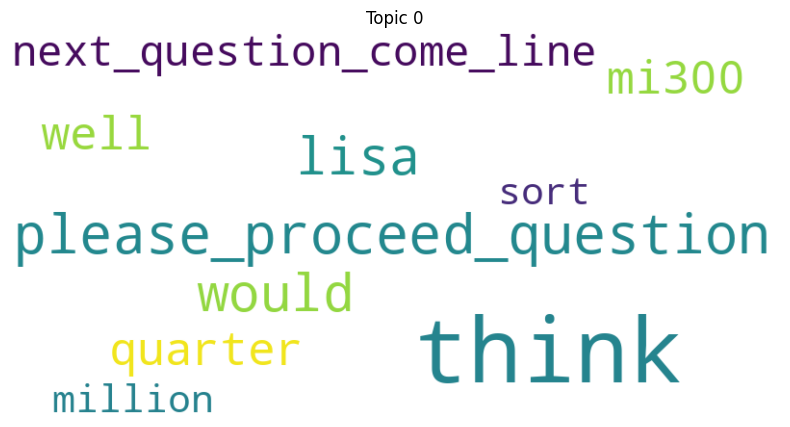

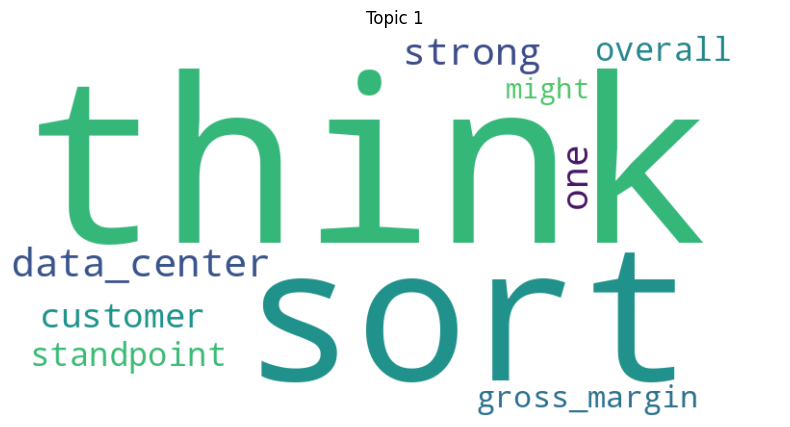

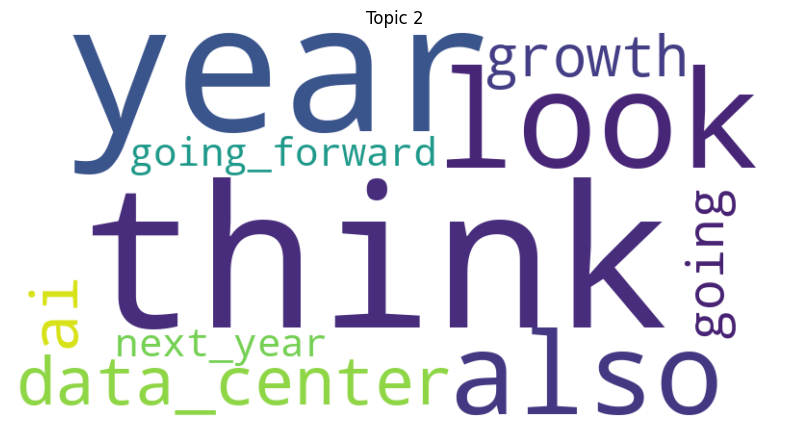

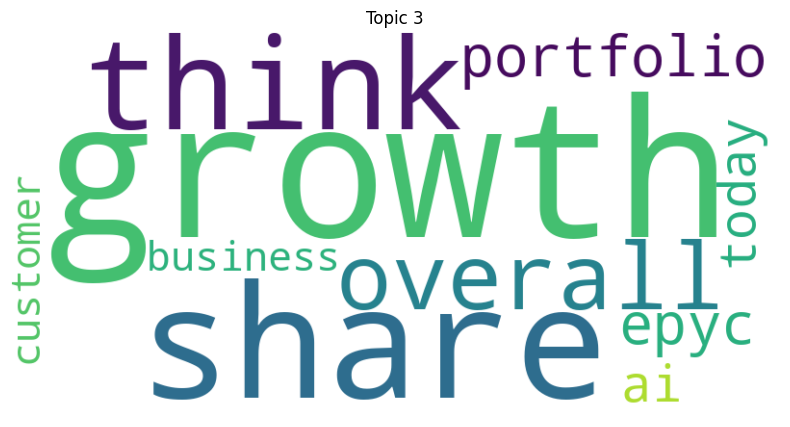

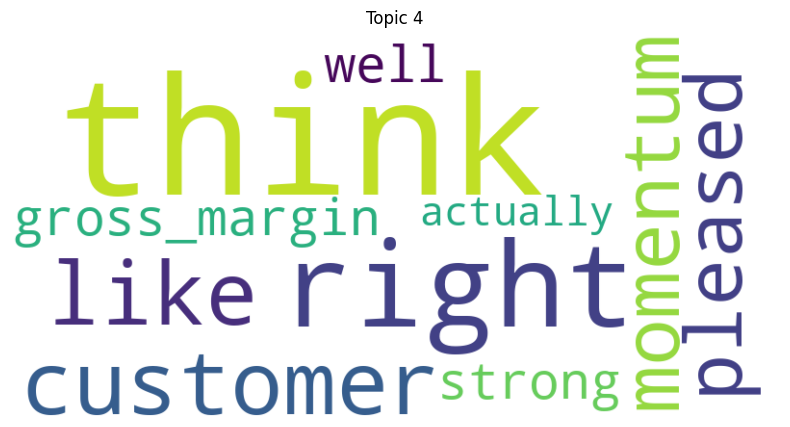

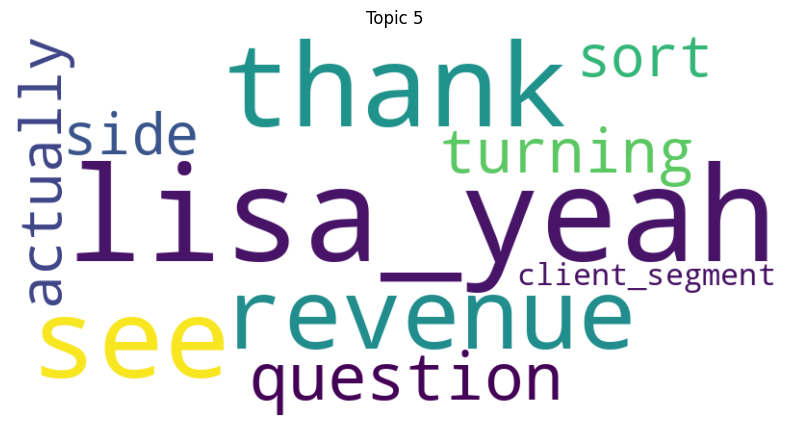

In [6]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, passes=10):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

def get_document_topics(lda_model, corpus):
    return [lda_model.get_document_topics(doc) for doc in corpus]

def get_most_representative_topic(document_topics):
    return max(document_topics, key=lambda x: x[1])[0]

def get_representativeness_score(document_topics, predicted_topic):
    return next((score for topic, score in document_topics if topic == predicted_topic), 0)

def perform_lda(text, num_topics_range=(2, 10), n_grams=True, passes=10):

    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(text)

    # Create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(tokens) for tokens in text]

    # Compute coherence values for different numbers of topics
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, texts=text, limit=num_topics_range[1], start=num_topics_range[0], passes=passes)

    # Find the optimal number of topics
    optimal_num_topics = num_topics_range[0] + coherence_values.index(max(coherence_values))

    # Train the LDA model with the optimal number of topics
    lda_model = model_list[coherence_values.index(max(coherence_values))]

    return lda_model

lda_model = perform_lda(text = processed_sentences_with_ngrams, num_topics_range=(2, 20), n_grams=True, passes=15)

# Get the topics and associated terms
topics = lda_model.print_topics(num_words=50)

# Create word clouds for each topic
for topic in topics:
    topic_number, word_distribution = topic
    word_distribution = dict(lda_model.show_topic(topic_number))

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_distribution)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_number}')
    plt.axis('off')
    plt.show()